In [1]:
%load_ext autoreload
%autoreload 2

# Scan and detect

## Line scan

Scanning imaging modes such as STEM works by scanning an electron probe across a sample and recording the scattering signal. As in earlier tutorials, we import our graphene potential and create a probe.

[autoreload of abtem failed: Traceback (most recent call last):
  File "c:\intelpython3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\intelpython3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\intelpython3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\intelpython3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "c:\users\jacob\pycharmprojects\abtem\abtem\__init__.py", line 4, in <module>
    from abtem.temperature import AbstractFrozenPhonons
ImportError: cannot import name 'AbstractFrozenPhonons' from 'abtem.temperature' (c:\users\jacob\pycharmprojects

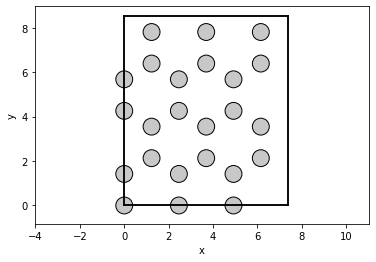

In [74]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read
from abtem.plot import show_atoms

atoms = read('graphene.cif') 
atoms = atoms.repeat((3, 2, 1))

atoms.center(vacuum=3,axis=2)

show_atoms(atoms)

In [69]:
from abtem.waves import Probe
from abtem.potentials import Potential

probe = Probe(energy=80e3, semiangle_cutoff=.03, focal_spread=60, defocus=50, device='gpu')
potential = Potential(atoms, sampling=.03).calculate().as_transmission_functions(probe.energy)

There . The `LineScan` scan the probe along a straight line 
the `CustomScan` object can scan over any arbitrary region given by an array of positions.

Below we create a linescan object, that scan between two atoms. The scan objects can be given as an argument in the plotting method of 2d arrays or the `show_atoms` function to visualise the scan region.

(<matplotlib.axes._subplots.AxesSubplot at 0x1872de9e308>,
 <matplotlib.image.AxesImage at 0x1872debce48>)

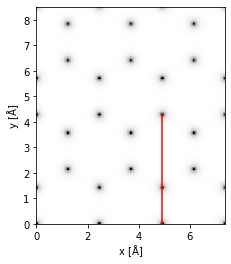

In [70]:
from abtem.scan import LineScan

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 3 * 1.42], gpts=100)

potential.show(scans=linescan)

The scan objects allows the creation of a generator of exit probes. The `max_batch` controls the number probes propagated simultaneously, larger batches allows for better parallelism and hence speed. The actual speedup will depend on the number of threads, hence GPU's are better at taking advantage of large batches. The batch size should be balanced by the memory requirement.

If `max_batch` is given as an integer it is the actual maximum number of waves per batch. If given as a string terminated by a 'b', e.g. '100Mb' or '4Gb', the maximum batch is calculated to fill the indicated amount of memory. Lastly, if given as a string terminated by a percent sign, e.g. '50%', maximum batch is allowed to fill '50%' of the available memory.

The following code generates 50 probes at different positions and propagates them through the potential.

In [71]:
generator = probe.generate_probes(linescan, potential, max_batch=50)

first_index, last_index, exit_probes = next(generator)

The memory usage in bytes of the batch can be obtained from the memory usage property, hence in this case the batches take up 157 Mb of memory.

In [72]:
exit_probes.array.shape, exit_probes.array.nbytes * 1e-6

((50, 246, 285), 28.044)

## Detect

In real experiments the exit probes are not directly detected, in abTEM, the way the signal is detected is controlled by the detector objects. There are several different types detectors, for now we focus on the basic `AnnularDetector`, this can represent the detector used in bright field, medium and high angle annular dark field microscopy, depending on the choice of integration region. The integration region is given by an inner and outer radius in radians; below we create three different types of detectors, and plot their respective integration regions.

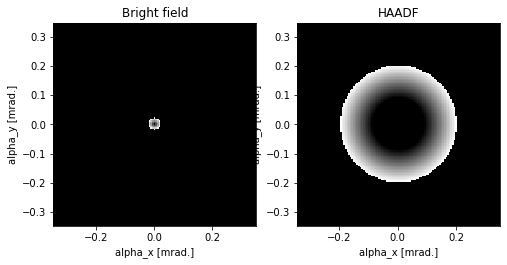

In [73]:
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

bright = AnnularDetector(inner=.0, outer=.02)
haadf = AnnularDetector(inner=.09, outer=.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

bright.show(potential.grid, probe.wavelength, ax=ax1, title='Bright field')
haadf.show(potential.grid, probe.wavelength, ax=ax2, title='HAADF');

The probes can be detected using the `.detect` method, this condenses each probe down to a single integrated intensity.

In [58]:
haadf.detect(exit_probes)

array([1.86758203e-04, 1.86045290e-04, 1.83977041e-04, 1.80633957e-04,
       1.76138274e-04, 1.70650717e-04, 1.64366065e-04, 1.57506816e-04,
       1.50315944e-04, 1.43048252e-04, 1.35960829e-04, 1.29305787e-04,
       1.23318852e-04, 1.18212141e-04, 1.14165552e-04, 1.11320798e-04,
       1.09775312e-04, 1.09579494e-04, 1.10734582e-04, 1.13192618e-04,
       1.16858027e-04, 1.21592231e-04, 1.27217601e-04, 1.33525275e-04,
       1.40283038e-04, 1.47242230e-04, 1.54149311e-04, 1.60752767e-04,
       1.66813028e-04, 1.72111613e-04, 1.76455898e-04, 1.79687398e-04,
       1.81685115e-04, 1.82370408e-04, 1.81704570e-04, 1.79693350e-04,
       1.76381116e-04, 1.71849417e-04, 1.66212034e-04, 1.59609743e-04,
       1.52202658e-04, 1.44164791e-04, 1.35677386e-04, 1.26921470e-04,
       1.18071221e-04, 1.09290457e-04, 1.00726407e-04, 9.25072236e-05,
       8.47385018e-05, 7.75034714e-05], dtype=float32)

Usually, we would like to condense the exit probes during the scan in order to save memory. Hence, the typical syntax for simulating STEM experiment requires giving the detector(s) as an argument of the scan object.

In [59]:
measurements = probe.scan(linescan, [haadf, bright], potential, max_batch=20, pbar=True)

The output is a dictionary of measurements with one entry per detector.

In [60]:
measurements[bright]

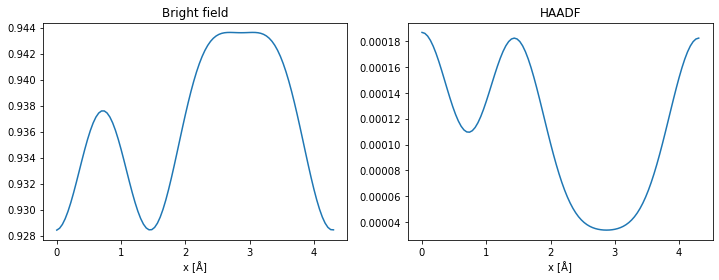

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
measurements[bright].show(ax=ax1, title='Bright field')
measurements[haadf].show(ax=ax2, title='HAADF')

In [61]:
measurements[haadf].write('linescan.hdf5')

'linescan.hdf5'

## Grid scan

The `GridScan` object is used essentially the same as the `LineScan` object. In the following we scan over a tilable section of of the potential. By specifying an output file ofr the detector, we dump the measurements directly to a file as they are made.

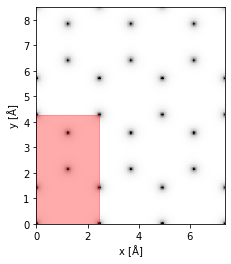

In [63]:
from abtem.scan import GridScan

detector = AnnularDetector(inner=.086, outer=.19, save_file='gridscan.hdf5')
gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

potential.show(scans=gridscan);

The number of positions in a densely sampled grid can obviously be large, hence it may be useful to show the progress as below.

In [64]:
measurement_files = probe.scan(gridscan, [detector], potential, max_batch=100, pbar=True)

In [65]:
measurement_files[detector]

'gridscan.hdf5'

We read back in the measurements from disk and tile it.

(<matplotlib.axes._subplots.AxesSubplot at 0x1872be72548>,
 <matplotlib.image.AxesImage at 0x1872c6e9a08>)

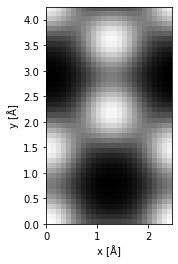

In [66]:
from abtem.measure import Measurement

measurement = Measurement.read('gridscan.hdf5')
measurement.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x1872c37f588>,
 <matplotlib.image.AxesImage at 0x1872de22c08>)

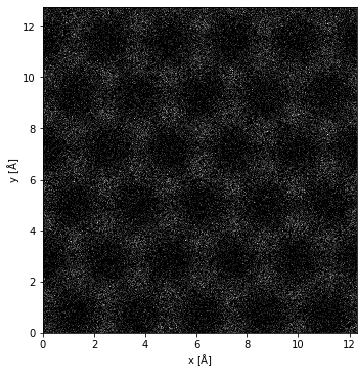

In [68]:
new_measurement = measurement.tile((5, 3))
new_measurement = new_measurement.interpolate(.04)
new_measurement = new_measurement.poisson_noise(500)

new_measurement.show(figsize=(6,6))

It is not possible to save directly to an image file during the scan, however, it is straightforward to export the measurement as an image. 

In [18]:
new_measurement.save_as_image('gridscan.tif')